# Train AE with data generated on MullerBrown potential 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.DoubleWellAlongCircle import DoubleWellAlongCircle
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset 

In [4]:
pot = DoubleWellAlongCircle(epsilon=0.1, )
import torch 
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
beta = 2
dt = 0.01
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 1 * 10**5

In [6]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [7]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

<Figure size 432x288 with 0 Axes>

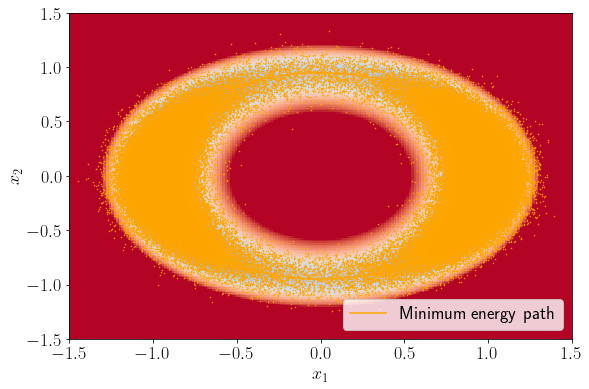

In [8]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

fig = plt.figure()
pot.set_2D_plot_grid_precision(200, 200)
fig, (ax) = plt.subplots(1, 1, figsize=(9, 6))
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.scatter(traj_dict1["x_traj"][:, 0], traj_dict1["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.scatter(traj_dict2["x_traj"][:, 0], traj_dict2["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend()

#plt.savefig("double_well_pot.png", format='png', dpi=160)

In [9]:
dataset = {"boltz_points": np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)}

In [10]:
dataset.keys()

dict_keys(['boltz_points'])

Import AE model 

In [11]:
from autoencoders.ae_models import DeepAutoEncoder
from autoencoders.train_aes import TainAEOneDecoder
from autoencoders.ae_models import DeepAutoEncoderDoubleDec
from autoencoders.train_aes import TainAETwoDecoder

Create autoencoder object

In [41]:
del(ae)
del(ae_training)

In [42]:
seed = 2 
set_all_seeds(seed)
ae = DeepAutoEncoderDoubleDec([2, 5, 5, 1], [1, 20, 20, 2], 0)
#ae = DeepAutoEncoder([2, 5, 5, 1], [1, 20, 20, 2], 0)

Created training object

In [43]:
ae_training = TainAETwoDecoder(ae, pot, dataset)
#ae_training = TainAEOneDecoder(ae, pot, dataset)

Set the training size and do the train-test split

In [44]:
ae_training.train_test_split(train_size=2 * 10**4)
ae_training.split_training_dataset_K_folds(6)
ae_training.set_train_val_data(0)

Set the optimizer 

In [45]:
ae_training.set_optimizer('Adam', 0.005, parameters_to_train='all')

Set the loss function parameters 

In [46]:
loss_params = {}
loss_params["mse_boltz_weight"] = 0. * 10**(0)
loss_params["mse_react_weight"] = 0. * 10**(0)
loss_params["var_enc_weight"] = 1.0 * 10**(4)
loss_params["squared_grad_boltz_weight"] = 1.0 * 10**(0)
loss_params["pen_points_weight"] = 0.0 * 10**(-1)
loss_params["pen_points_mse_weight"] = 0.0 * 10**(-1)
loss_params["n_wait"] = 100
ae_training.set_loss_weight(loss_params)

l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
var_dist_dec_weight value not provided, set to default value of:  0.0
n_bins_var_dist_dec value not provided, set to default value of:  20


Set the max number of epoch and batch size 

In [47]:
batch_size = 1 * 10**3
max_epochs = 10000

Train 

In [48]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 1175 epochs.



Plot the evolution of the loss stating from the 100th epoch 

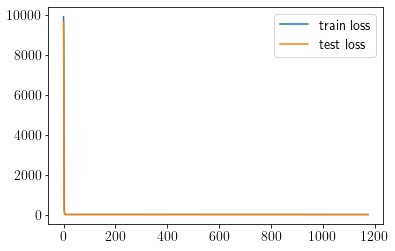

In [49]:
plt.figure()
plt.plot(loss_dict["train_loss"][:], label='train loss')
plt.plot(loss_dict["test_loss"][:], label='test loss')
plt.legend()

Plot the conditionnal averages on the potential heat map 

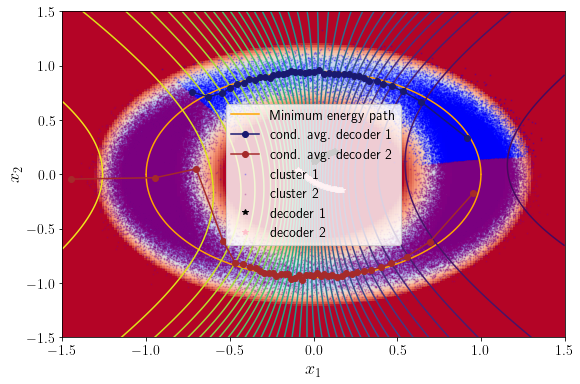

In [51]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ae_training.plot_encoder_iso_levels(ax, 40)
z_bin, Esp_X_given_z_boltz_dec1, Esp_X_given_z_boltz_dec2 = ae_training.plot_conditional_averages(ax, 40, with_react_dens=False)
#z_bin, Esp_X_given_z_reac = ae_training.plot_conditional_averages(ax, 40, with_react_dens=True)
Esp_X_given_z_reac_dec1 = Esp_X_given_z_boltz_dec1
Esp_X_given_z_reac_dec2 = Esp_X_given_z_boltz_dec2
ax.set_xlabel(r'$x_1$', fontsize=18)
ax.set_ylabel(r'$x_2$', fontsize=18)
ax.legend(loc='center')
#plt.savefig("DWC_1dec.png", format='png', dpi=160)
plt.savefig("double_decoder_c.png", format='png', dpi=160)

In [ ]:
Esp_X_given_z_weighted_dec1 = (loss_params["mse_boltz_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"])) * Esp_X_given_z_boltz_dec1 + (loss_params["mse_react_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"]))  * Esp_X_given_z_reac_dec1
Esp_X_given_z_weighted_dec2 = (loss_params["mse_boltz_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"])) * Esp_X_given_z_boltz_dec2 + (loss_params["mse_react_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"]))  * Esp_X_given_z_reac_dec2

f_dec_X_given_z_mean_dec1 = ae_training.ae.decoder1(ae_training.ae.encoder(torch.tensor(Esp_X_given_z_weighted_dec1.astype('float32')))).detach().numpy()
f_dec_X_given_z_mean_dec2 = ae_training.ae.decoder2(ae_training.ae.encoder(torch.tensor(Esp_X_given_z_weighted_dec2.astype('float32')))).detach().numpy()

In [ ]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ae_training.plot_encoder_iso_levels(ax, 100)
#ax.plot(Esp_X_given_z_weighted[:, 0], Esp_X_given_z_weighted[:, 1], '-o', color='blue', label='cond. avg.')
ax.plot(f_dec_X_given_z_mean_dec1[:, 0], f_dec_X_given_z_mean_dec1[:, 1], '-*', color='gold', label='decoder1')
ax.plot(f_dec_X_given_z_mean_dec2[:, 0], f_dec_X_given_z_mean_dec2[:, 1], '-*', color='cyan', label='decoder2')

ax.set_xlabel(r'$x_1$', fontsize=18)
ax.set_ylabel(r'$x_2$', fontsize=18)
ax.legend(loc='center')
#plt.savefig("DWC_2dec_cstrained.png", format='png', dpi=160)

Plot convergence of the principal curve 

In [ ]:
ae_training.plot_principal_curve_convergence(100)

Plot the points that are in different clusters (different decoder) 

In [ ]:
boltz_points = torch.tensor(ae_training.dataset["boltz_points"].astype('float32'))
boltz_points_decoded1 = ae_training.ae.decoder1(ae_training.ae.encoder(boltz_points))
boltz_points_decoded2 = ae_training.ae.decoder2(ae_training.ae.encoder(boltz_points))
x1 = torch.sum((boltz_points - boltz_points_decoded1) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded2) ** 2,
            dim=1).detach().numpy()
x2 = torch.sum((boltz_points - boltz_points_decoded2) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded1) ** 2,
            dim=1).detach().numpy()

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.scatter(ae_training.dataset["boltz_points"][x1][:, 0], ae_training.dataset["boltz_points"][x1][:, 1], color='blue', label='decoder1', s=1)
ax.scatter(ae_training.dataset["boltz_points"][x2][:, 0], ae_training.dataset["boltz_points"][x2][:, 1], color='purple', label='decoder2', s=1)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ae_training.plot_encoder_iso_levels(ax, 20)
ax.legend()